In [31]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torchvision import datasets, transforms, models, utils
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
!kaggle datasets download -d omkargurav/face-mask-dataset

face-mask-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
from zipfile import ZipFile
with ZipFile('face-mask-dataset.zip', 'r') as zf:
    zf.extractall('G:')

In [32]:
data_dir = "G:\data"

train_transform = torchvision.transforms.Compose([transforms.ToTensor(),
                                                  transforms.Resize((32,32)),
                                                  transforms.RandomCrop(32),
                                                 ])

In [33]:
train_dataset = torchvision.datasets.ImageFolder(data_dir, transform = train_transform)

trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle = True
)

print((train_dataset[0][0].shape))

torch.Size([3, 32, 32])


In [34]:
K = len(set(train_dataset.targets))
print(K)

2


In [35]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
        )
        
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, K)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = F.dropout(x, p=0.12)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.8)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.6)
        x = self.fc3(x)
        return x

In [36]:
model = CNN(K)

In [37]:
model.to(device)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [39]:
def facemask(model, criterion, optimizer, trainloader, epochs):
  train_losses = np.zeros(epochs)

  for i in range(epochs):
    train_loss = []
    for inputs, targets in trainloader:
      inputs, targets = inputs.to(device), targets.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, targets)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
      
    train_loss = np.mean(train_loss)

    train_losses[i] = train_loss

    print(f'Epoch:{i+1}/{epochs}, Train Loss: {train_loss:.4f}')
    
  return train_losses

In [40]:
train_losses = facemask(model, criterion, optimizer, trainloader, epochs=10)

Epoch:1/10, Train Loss: 0.3778
Epoch:2/10, Train Loss: 0.1972
Epoch:3/10, Train Loss: 0.1395
Epoch:4/10, Train Loss: 0.1305
Epoch:5/10, Train Loss: 0.0973
Epoch:6/10, Train Loss: 0.0794
Epoch:7/10, Train Loss: 0.0687
Epoch:8/10, Train Loss: 0.0820
Epoch:9/10, Train Loss: 0.0646
Epoch:10/10, Train Loss: 0.0521


In [41]:
PATH = "FaceMask.pt"

# save

torch.save(model, PATH)

In [42]:
# load

model = torch.load(PATH)
model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=

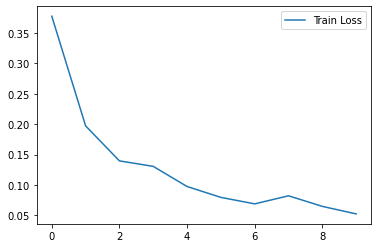

In [43]:
plt.plot(train_losses, label = "Train Loss")
plt.legend()
plt.show()

In [45]:
correct = 0
total = 0

for inputs, targets in trainloader:
    inputs, targets = inputs.to(device), targets.to(device)

    output = model.forward(inputs)

    total += criterion(output, targets).item()

    ps = torch.exp(output).data
    equality = (targets.data == ps.max(1)[1])

    correct += equality.type_as(torch.FloatTensor()).mean()

print("Train Accuracy: {:.3f}%".format(100 * correct/len(trainloader)))

Train Accuracy: 98.044%


In [46]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

torch.Size([64, 3, 32, 32]) torch.Size([64])


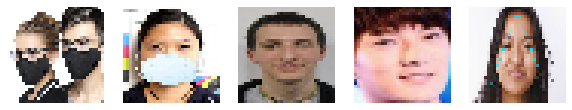

In [51]:
model.to('cpu')
model.eval()

images, targets = next(iter(trainloader))
print(images.shape, targets.shape)
fig, axes = plt.subplots(figsize=(10, 10), ncols=5)

for i in range(5):
    ax = axes[i]
    imshow(images[i], ax=ax)


In [52]:
with torch.no_grad():
    output = model.forward(images)

ps = F.softmax(output,dim=1)


In [63]:
rand_img = np.random.randint(64, size=1)[0]
rand_img

26

In [64]:
probability = ps[rand_img].data.numpy().squeeze()
probability

array([1.000000e+00, 6.074323e-13], dtype=float32)

<AxesSubplot:>

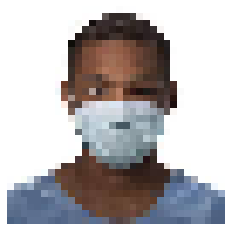

In [65]:
imshow(images[rand_img])

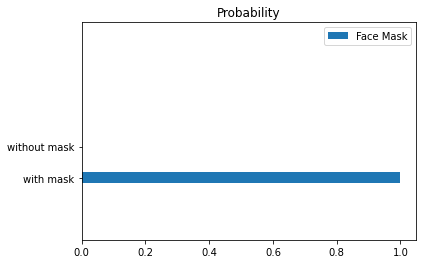

In [66]:
ind = np.arange(2)
targets = ['with mask','without mask']
width = 0.35
locations = ind

class_probability = plt.barh(ind, probability, width, alpha=1, label = 'Face Mask')

plt.yticks(np.arange(2))
plt.title('Probability')
plt.yticks(locations,targets)

#legend
plt.legend()
plt.ylim(top=5)
plt.ylim(bottom=-2)
plt.show();